# Configuration

In [ ]:
!pip install gensim --upgrade
!pip install emoji --upgrade
!pip install -q kaggle
!pip3 install --upgrade -e git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip install contractions
!pip install vaderSentiment
!pip install NRCLex --upgrade
!pip install yellowbrick --upgrade
!pip3 install pickle5

     |████████████████████████████████| 23.9 MB 93 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 184 kB 4.8 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=5b0cf4e83ea0944f09f701a1be712ec4924a111963762c93e8079e4df7abdcc5
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji
Obtaining twint from git+https://github.com/twintproject/twint.git@origin/master#egg=twint
  Cloning https://github.com/twintproject/twint.git (to revision origin/master) to ./src/twint
  Running command git clone -q https://github.com/twintproject/twint.git /content/src/twint
  Running command git checkout -q origin/master
     |████████████████████████████████| 1.3 MB 5.0 MB/s 
     |████████████████████████████████| 263 kB 20.4 MB/s 
     |██████

In [ ]:
##########
# IMPORT #
##########

# Utility
from collections import Counter
import emoji
import itertools
import json
import logging
import numpy as np
import os
import pandas as pd
import pickle5 as pickle
import random
import re
import string
import time
from string import punctuation


# Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

# Nltk
import nltk
from nltk import download, ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
download('stopwords')
download('wordnet')
download('punkt')
download('averaged_perceptron_tagger')
STOPWORDS = stopwords.words("english") + ['rt']

# Sk-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import adjusted_rand_score, cohen_kappa_score
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Scipy 
import scipy.stats as st
from scipy.spatial.distance import cdist

# Gensim
import gensim
from gensim import corpora
from gensim import models

# Yellowbrick
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance


# Word Cloud
from wordcloud import WordCloud

# Pre-processing
from functools import reduce
from bs4 import BeautifulSoup 

# Contraction
import contractions

# VADER
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# NRCLex
from nrclex import NRCLex

# Chi square 
from scipy.stats import chi2
from scipy.stats import chi2_contingency

#####################
#  REPRODUCIBILITY  #
#####################

# Seed value
SEED_VALUE= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(SEED_VALUE)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data


We read data from the csv and pickle files by relying on `pandas` library:

In [ ]:
csv_file = pd.read_csv('/content/drive/MyDrive/NLP_BigProject/CLPsych_files/anonymized_user_info_by_chunk.csv')

In [ ]:
with open('/content/drive/MyDrive/NLP_BigProject/CLPsych_files/depressed_dataset.pkl', "rb") as fh:
  depressed_dataset = pickle.load(fh)
with open('/content/drive/MyDrive/NLP_BigProject/CLPsych_files/control_dataset.pkl', "rb") as fh:
  control_dataset = pickle.load(fh)

In [ ]:
df = {'user_name': [],
      'text': [],
      'CLPsych':[]}

for col in depressed_dataset.columns:
  for text in depressed_dataset[col]:
    df['user_name'].append(col)
    df['text'].append(text)
    df['CLPsych'].append(1)

for col in control_dataset.columns:
  for text in control_dataset[col]:
    df['user_name'].append(col)
    df['text'].append(text)
    df['CLPsych'].append(0)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.DataFrame(df)
df.dropna(inplace=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head(100)

,user_name,text,CLPsych
0,ms_0SI9_YGA2B,"""@lEIyVRcKQ_: I hate nigga who act like hoes""",1
1,wnGRvO19SP,"@qycgqPSS8 hi zayn :)\n🎶🌻🎶🌻🎶🌻🎶🌻🎶🌻🎶🌻🎶\nYou make me so happy, you've helped so much! A follow would mean a lot :)\n🌴🌸🌴🌸🌴🌸🌴🌸🌴🌸🌴🌸🌴\nI love you! ☀32",1
2,oErPllMNtNSN,RT @u1PNPhIC8Emt: If any of you think I swear a lot please let me fucking know and I'll fucking stop.,0
3,ukroWtu0tArHF,Also we are marrief while in the US.,1
4,bTPjTsO,Theres no good guys left.,0
...,...,...,...
95,gB24pkmo_,RT @suIlrkRe: Wassup LA! Baldwin Park already crackin in my 1hr being here,0
96,r1Zml0r9YuBTm,RT @wQQzua6xJm28: I just want us together. 😘,1
97,wbdI93j_weySC_,RT @bk3TBXeuDIf3m: @wbdI93j_weySC_ @bNm4jepgd8e35 I still don't know what song it is!!! ,0
98,qFpWAPR,RT @nLq3UChfmgJDX: Coooorn chhhowdaaa @qFpWAPR 😂😂😂😂,0


# Exploratory Data Analysis

Our dataset contains 3 features:

 1.   `user_name [str]`    
 Anonymized user name.                    
 9.   `text [str]`  
 Text of the tweet.              
 10.  `CLPsych [int]`   
  When 1, indicates that the tweet belongs to a depressed user. 



In the following sections we will take a closer look to our data by analyzing unique values.



## Unique Values
Let's count the unique value of each feature: 
* there are some identical tweets that we have to remove.

In [ ]:
print("Data size:", len(df))
for feature in df.columns.tolist():
  print("{} unique values -> {}".format(feature, len(df[feature].unique()))) 

Data size: 1773426
user_name unique values -> 823
text unique values -> 1735358
CLPsych unique values -> 2


 **Remove text duplicates**



In [ ]:
print("Data size:", len(df))
df.drop_duplicates(subset='text', keep="last", inplace=True)
df.reset_index(inplace=True, drop = True)
print("Data size:", len(df))

Data size: 1773426
Data size: 1735360


## Reduce Dataframe

The dataframe contains about $1.73$ million tweets, we decided to keep only $640K$ tweets to reduce the computational time.  
We selected 320K tweets of each class (depressed/not depressed) in order to have a balanced dataset.


In [ ]:
df = pd.concat([df[df.CLPsych == 1][:320000], df[df.CLPsych == 0][:320000]])
df = df.sample(frac=1).reset_index(drop = True)

# Text Preprocessing

Let's apply to *CLPsych* tweets the same preprocessing procedure used with *Covid-19* tweets. We only slightly modify the list of stopwords by removing words related to COVID-19, and adding the term "rt" which means *Re-Tweet*, i.e. *the act of taking someone's tweet and posting it as your own*.

After the cleaning procedure, we do not drop tweets duplicates, since we are interested in preserving all the tweets for our labelling task.


In [ ]:
target = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '!', '?', '.', ',', '"', "'"];
specialList = {
        'serifBold' : ['𝐚', '𝐛', '𝐜', '𝐝', '𝐞', '𝐟', '𝐠', '𝐡', '𝐢', '𝐣', '𝐤', '𝐥', '𝐦', '𝐧', '𝐨', '𝐩', '𝐪', '𝐫', '𝐬', '𝐭', '𝐮', '𝐯', '𝐰', '𝐱', '𝐲', '𝐳', '𝐀', '𝐁', '𝐂', '𝐃', '𝐄', '𝐅', '𝐆', '𝐇', '𝐈', '𝐉', '𝐊', '𝐋', '𝐌', '𝐍', '𝐎', '𝐏', '𝐐', '𝐑', '𝐒', '𝐓', '𝐔', '𝐕', '𝐖', '𝐗', '𝐘', '𝐙', '𝟎', '𝟏', '𝟐', '𝟑', '𝟒', '𝟓', '𝟔', '𝟕', '𝟖', '𝟗', '❗', '❓'],
        'serifItalic' : ['𝑎', '𝑏', '𝑐', '𝑑', '𝑒', '𝑓', '𝑔', 'ℎ', '𝑖', '𝑗', '𝑘', '𝑙', '𝑚', '𝑛', '𝑜', '𝑝', '𝑞', '𝑟', '𝑠', '𝑡', '𝑢', '𝑣', '𝑤', '𝑥', '𝑦', '𝑧', '𝐴', '𝐵', '𝐶', '𝐷', '𝐸', '𝐹', '𝐺', '𝐻', '𝐼', '𝐽', '𝐾', '𝐿', '𝑀', '𝑁', '𝑂', '𝑃', '𝑄', '𝑅', '𝑆', '𝑇', '𝑈', '𝑉', '𝑊', '𝑋', '𝑌', '𝑍'],
        'serifBoldItalic' : ['𝒂', '𝒃', '𝒄', '𝒅', '𝒆', '𝒇', '𝒈', '𝒉', '𝒊', '𝒋', '𝒌', '𝒍', '𝒎', '𝒏', '𝒐', '𝒑', '𝒒', '𝒓', '𝒔', '𝒕', '𝒖', '𝒗', '𝒘', '𝒙', '𝒚', '𝒛', '𝑨', '𝑩', '𝑪', '𝑫', '𝑬', '𝑭', '𝑮', '𝑯', '𝑰', '𝑱', '𝑲', '𝑳', '𝑴', '𝑵', '𝑶', '𝑷', '𝑸', '𝑹', '𝑺', '𝑻', '𝑼', '𝑽', '𝑾', '𝑿', '𝒀', '𝒁', '𝟎', '𝟏', '𝟐', '𝟑', '𝟒', '𝟓', '𝟔', '𝟕', '𝟖', '𝟗', '❗', '❓'],
        'sans' : ['𝖺', '𝖻', '𝖼', '𝖽', '𝖾', '𝖿', '𝗀', '𝗁', '𝗂', '𝗃', '𝗄', '𝗅', '𝗆', '𝗇', '𝗈', '𝗉', '𝗊', '𝗋', '𝗌', '𝗍', '𝗎', '𝗏', '𝗐', '𝗑', '𝗒', '𝗓', '𝖠', '𝖡', '𝖢', '𝖣', '𝖤', '𝖥', '𝖦', '𝖧', '𝖨', '𝖩', '𝖪', '𝖫', '𝖬', '𝖭', '𝖮', '𝖯', '𝖰', '𝖱', '𝖲', '𝖳', '𝖴', '𝖵', '𝖶', '𝖷', '𝖸', '𝖹', '𝟢', '𝟣', '𝟤', '𝟥', '𝟦', '𝟧', '𝟨', '𝟩', '𝟪', '𝟫'],
        'sansBold' : ['𝗮', '𝗯', '𝗰', '𝗱', '𝗲', '𝗳', '𝗴', '𝗵', '𝗶', '𝗷', '𝗸', '𝗹', '𝗺', '𝗻', '𝗼', '𝗽', '𝗾', '𝗿', '𝘀', '𝘁', '𝘂', '𝘃', '𝘄', '𝘅', '𝘆', '𝘇', '𝗔', '𝗕', '𝗖', '𝗗', '𝗘', '𝗙', '𝗚', '𝗛', '𝗜', '𝗝', '𝗞', '𝗟', '𝗠', '𝗡', '𝗢', '𝗣', '𝗤', '𝗥', '𝗦', '𝗧', '𝗨', '𝗩', '𝗪', '𝗫', '𝗬', '𝗭', '𝟬', '𝟭', '𝟮', '𝟯', '𝟰', '𝟱', '𝟲', '𝟳', '𝟴', '𝟵', '❗', '❓'],
        'sansItalic' : ['𝘢', '𝘣', '𝘤', '𝘥', '𝘦', '𝘧', '𝘨', '𝘩', '𝘪', '𝘫', '𝘬', '𝘭', '𝘮', '𝘯', '𝘰', '𝘱', '𝘲', '𝘳', '𝘴', '𝘵', '𝘶', '𝘷', '𝘸', '𝘹', '𝘺', '𝘻', '𝘈', '𝘉', '𝘊', '𝘋', '𝘌', '𝘍', '𝘎', '𝘏', '𝘐', '𝘑', '𝘒', '𝘓', '𝘔', '𝘕', '𝘖', '𝘗', '𝘘', '𝘙', '𝘚', '𝘛', '𝘜', '𝘝', '𝘞', '𝘟', '𝘠', '𝘡'],
        'sansBoldItalic' : ['𝙖', '𝙗', '𝙘', '𝙙', '𝙚', '𝙛', '𝙜', '𝙝', '𝙞', '𝙟', '𝙠', '𝙡', '𝙢', '𝙣', '𝙤', '𝙥', '𝙦', '𝙧', '𝙨', '𝙩', '𝙪', '𝙫', '𝙬', '𝙭', '𝙮', '𝙯', '𝘼', '𝘽', '𝘾', '𝘿', '𝙀', '𝙁', '𝙂', '𝙃', '𝙄', '𝙅', '𝙆', '𝙇', '𝙈', '𝙉', '𝙊', '𝙋', '𝙌', '𝙍', '𝙎', '𝙏', '𝙐', '𝙑', '𝙒', '𝙓', '𝙔', '𝙕', '𝟎', '𝟏', '𝟐', '𝟑', '𝟒', '𝟓', '𝟔', '𝟕', '𝟖', '𝟗', '❗', '❓'],
    }


def format(text):
  for value in specialList.values():
    for i, char in enumerate(value):
        text = text.replace(char, target[i])
  return text


class CleanText(BaseEstimator, TransformerMixin):

    # DIGITS
    def remove_digits(self, input_text):
        """Removes any digits from the text."""
        return re.sub(r'\d+', ' ', input_text)
    
    # MENTIONS
    def remove_mentions(self, input_text):
        """Removes mentions from the text by finding them through @""" 
        return re.sub(r'@\w+', ' ', input_text)

    # PUNCTUATION
    def remove_punctuation(self, input_text):
        """Replaces any punctuation symbol by a space."""
        punct = string.punctuation + '…“”￼＆—●'
        trantab = str.maketrans(punct, len(punct)*' ')
        return input_text.translate(trantab) 
    
    # STOPWORDS
    def remove_stopwords(self, input_text):
        """Removes english stopwords"""
        words = input_text.split() 
        clean_words = [word for word in words if word not in STOPWORDS] 
        return " ".join(clean_words) 
    
    # URLS
    def remove_urls(self, input_text):
        """Removes external links from the text by finding them through http(s)""" 
        return re.sub(r'http.?://[^\s]+[\s]?', ' ', input_text)
    
    # STEMMING
    def stemming(self, input_text):
        """ Returns the input text stemmed using Snowball algorithms."""
        stemmer = SnowballStemmer(language="english")
        words = input_text.split() 
        stemmed_words = [stemmer.stem(word) for word in words]
        return " ".join(stemmed_words)

    # LEMMATIZATION
    def lemmatize(self, input_text):
        """ Returns the input text lemmatized."""
        lemmatizer = WordNetLemmatizer()
        words = input_text.split() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmatized_words)
    
    # EMOJI
    def tranform_emoji(self, input_text):
        """ Transforms emoji in the corresponding word."""
        clean_text = emoji.demojize(input_text, delimiters=("_", "_"))
        return re.sub(r'_', ' ', clean_text) 

    # LOWER
    def to_lower(self, input_text):
        return input_text.lower()

    # APOSTROPHE
    def apostrophe(self, input_text):
       return re.sub(r'‘', "'", input_text) 

    # FORMAT
    def remove_format(self, input_text):
        return format(input_text)

    # CONTRACTIONS - NO VADER 
    def expand_contractions(self, input_text):
        return contractions.fix(input_text)

    #-----------------
    # VADER FORMAT
    #------------------
    # CONTRACTIONS
    def expand_contractions_vader(self, input_text):
      """
      Since VADER works well with slang, if mode == 3 (VADER)
      we do not transform the slang in the text (slang = False)
      """
      return contractions.fix(input_text, slang = False)
    
    # STRIP TEXT 
    def strip_text(self,input_text):
      return input_text.strip()
    
    # HASTAGS 
    def hashtags(self, input_text):
      return input_text.replace("#", " ")

    # TRAILING 
    def trailing(self, input_text):
      return input_text.replace('\n', " ").replace("\r", " ")

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
      """
      clean_X = X.apply(self.remove_format)\
              .apply(self.to_lower)\
              .apply(self.remove_mentions)\
              .apply(self.remove_urls)\
              .apply(self.tranform_emoji)\
              .apply(self.remove_digits)\
              .apply(self.remove_punctuation)\
              .apply(self.apostrophe)\
              .apply(self.expand_contractions)\
              .apply(self.lemmatize)\
              .apply(self.remove_stopwords)
      """
      clean_X = X.apply(self.remove_format)\
              .apply(self.to_lower)\
              .apply(self.remove_mentions)\
              .apply(self.remove_urls)\
              .apply(self.tranform_emoji)\
              .apply(self.remove_digits)\
              .apply(self.remove_punctuation)\
              .apply(self.apostrophe)\
              .apply(self.expand_contractions)\
              .apply(self.stemming)\
              .apply(self.remove_stopwords)

      return clean_X
      

In [ ]:
# WARNING: time consuming!

%%time 
ct = CleanText() 
df['clean_text'] = ct.fit(df.text).transform(df.text)


CPU times: user 6min 6s, sys: 721 ms, total: 6min 7s
Wall time: 6min 7s


In [ ]:
df[['text', 'clean_text', 'CLPsych']].head(20)

,text,clean_text,CLPsych
0,@u70KWGKqEY5QOW no as in dont turn back just finish what you were meant to do which is eat them,turn back finish meant eat,0
1,"Secondly a world where it is much more accessible to fulfil your talents, to many talented people are unable to achieve their dreams",second world much access fulfil talent mani talent peopl unabl achiev dream,1
2,RT @hftq3R6MM: Alexandra Tyler http://t.co/oUW:rp9XCU,alexandra tyler,0
3,life update: @noLLdwv0MRdtB and are watching the athletics and meowing at each other,life updat watch athlet meow,1
4,@jgkcOlGewc08hXI text me,text,0
5,"RT @fd5TbP81Up8h: You don't need good memory, if all you tell is the truth.",need good memori tell truth,0
6,I think myself right into a bad mood,think right bad mood,0
7,Eyes red.... zzzzzzzzzzz,eye red zzzzzzzzzzz,0
8,RT @xUap50: Paul Krugman: “Madness of the GOP is the central issue of our time” http://t.co/Hpx9yT5zoe via @tRezn,paul krugman mad gop central issu time via,0
9,@fDwQarS do you watch Food Hospital? covered fodmap diet for IBS patient. enormous improvement … have no gallbladder so have to watch fats.,watch food hospit cover fodmap diet ib patient enorm improv gallbladd watch fat,1


#Feature Extraction
After data pre-processing, we feed our models with the features that reflect users’ language habits in Twitter. To explore the users’ linguistic usage in the tweets, we decided to look at specific features by taking inspiration from existing works on depression detection (see the project report for more details).

##N-gram Features

We use TF-IDF vectorizer from the scikit-learn Python library on preprocessed tweets. For each class (depressed/not depressed) we restrict the term-document matrix to the first $100$ most frequent unigrams and $100$ most frequent bigrams.  
Then, we filter out the n-grams in common to both depressed and control tweets, and we cast to integers their tf-idf values to reduce the noise and to give the same weights to those unigrams/bigrams that differ in tf-idf for less than 1 unit.  
Finally, we prepare a vector of fetaures by encoding each tweets with the weighted count of each pre-defined unigram and bigram. The weight assign to each occurrence of a unigram/bigram is exactly the tf-idf value of the unigram/bigram itself.


In [ ]:
def get_top_ngrams(data, ngrams=(1,1), N = 100):
    """
    Returns the top N n-grams ranked according to TF-IDF.
    """
    word_vectorizer = TfidfVectorizer(ngram_range=ngrams, analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(data)
    index = word_vectorizer.get_feature_names()
    frequencies = sparse_matrix.sum(axis=0).T
    ngrams_freq = pd.DataFrame(frequencies, index, columns=['tf-idf'])
    return ngrams_freq.sort_values(by = 'tf-idf', ascending=False)[:N]

Get the top 100 bigrams and unigrams ranked according to TF-IDF:

In [ ]:
N = 100
top_unigrams_control = get_top_ngrams(df.clean_text[df.CLPsych == 0], (1,1), N)
top_bigrams_control = get_top_ngrams(df.clean_text[df.CLPsych == 0], (2,2), N)
top_unigrams_depr = get_top_ngrams(df.clean_text[df.CLPsych == 1], (1,1), N)
top_bigrams_depr = get_top_ngrams(df.clean_text[df.CLPsych == 1], (2,2), N)

Filter out the n-grams in common to both depressed and control tweets.

In [ ]:
common_unigrams = []
for term1 in top_unigrams_control.index:
  for term2 in top_unigrams_depr.index:
    if term1 == term2:
      common_unigrams.append(term2)
index = [x for x in top_unigrams_depr.index if x not in common_unigrams]
top_unigrams_depr = top_unigrams_depr.loc[index]
print("Filtered out {} unigrams.".format(len(common_unigrams)))

Filtered out 89 unigrams.


In [ ]:
common_bigrams = []
for term1 in top_bigrams_control.index:
  for term2 in top_bigrams_depr.index:
    if term1 == term2:
      common_bigrams.append(term2)
index = [x for x in top_bigrams_depr.index if x not in common_bigrams]
top_bigrams_depr = top_bigrams_depr.loc[index]
print("Filtered out {} bigrams.".format(len(common_bigrams)))

Filtered out 63 bigrams.


We cast to integers the tf-idf values to reduce the noise and to give the same weights to those unigrams/bigrams that differ in tf-idf for less than 1 unit.

In [ ]:
top_unigrams_depr = top_unigrams_depr.astype(int)

In [ ]:
top_unigrams_depr

,tf-idf
cri,1267
omg,1155
mean,1116
yeah,1098
stop,1072
everyon,1022
two,989
help,974
okay,960
live,960


In [ ]:
top_bigrams_depr = top_bigrams_depr.astype(int)

In [ ]:
top_bigrams_depr

,tf-idf
pleas follow,620
love much,455
follow love,337
see pleas,235
cherri blossom,214
would mean,209
thank much,164
follow would,161
heart red,154
mean world,148


###Prepare vector of n-gram features

In [ ]:
class Tweets_NGrams(BaseEstimator, TransformerMixin):
    """
    Class designed to text features from raw tweets.
    """
    
    def count_regex(self, pattern, tweet, weight):
        """ Returns the number of correspondences of the given regex."""
        if self.weighted_count:
           return weight * len(re.findall(pattern, tweet, re.IGNORECASE))
        else:
          return len(re.findall(pattern, tweet, re.IGNORECASE))
    
    def fit(self, X, y = None, **fit_params):
        self.target_features = fit_params['target_features']
        self.weighted_count = fit_params['weighted_count']
        return self
    
    def transform(self, X):
        
        features = {}
        for feature in self.target_features.index:
          pattern = r"(\b"+feature+")"
          features[feature] = X.apply(lambda x: self.count_regex(pattern, x, weight = self.target_features['tf-idf'].loc[feature])) 
        
        df = pd.DataFrame(features)
        
        return df

In [ ]:
# Example
sample_text = pd.Series({1:"feel better blue heart",
                         2:"cri omg",
                         3:"cri occri Cri"})
transformer = Tweets_NGrams()
test_features = transformer.fit_transform(sample_text, target_features=top_unigrams_depr, weighted_count = True)
test_features

,cri,omg,mean,yeah,stop,everyon,two,help,okay,live,red
1,0,0,0,0,0,0,0,0,0,0,0
2,1267,1155,0,0,0,0,0,0,0,0,0
3,2534,0,0,0,0,0,0,0,0,0,0


In [ ]:
# WARNING: Time consuming!
%%time
transformer = Tweets_NGrams()
df_unigrams = transformer.fit_transform(df.clean_text, target_features=top_unigrams_depr, weighted_count = True)
df_bigrams = transformer.fit_transform(df.clean_text, target_features=top_bigrams_depr, weighted_count = True)

CPU times: user 10min 24s, sys: 1.42 s, total: 10min 25s
Wall time: 10min 26s


In [ ]:
df_unigrams

,cri,omg,mean,yeah,stop,everyon,two,help,okay,live,red
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,960,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
639995,0,0,0,0,0,0,0,0,0,0,0
639996,0,0,0,0,0,0,0,0,0,960,0
639997,0,0,0,0,0,0,0,0,0,0,0
639998,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_bigrams

,pleas follow,love much,follow love,see pleas,cherri blossom,would mean,thank much,follow would,heart red,mean world,realli need,even know,make feel,follow peopl,sparkl heart,welcometweet via,unfollow follow,make happi,first time,good night,happen see,blossom cherri,want get,sound like,follow unfollow,go go,blue heart,feel better,squint face,want know,much love,heart two,cross line,love lt,go bed,everi time,year ago
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
639996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
639997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
639998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Language predictors of depression and Tweets features

Depression is marked by linguistic predictors such as increased perceptual processes, references to sadness and discrepancies or greater negative emotions.  
Thus, we select a list of language predictors of depression and we count their occurrences into the original, un-preprocessed tweets by defining a custom transformer and relying on regular expressions.  
Here is the list of language predictors organized in different semantic clusters:

  - self = I'm, I am, I was, I wasn't, my, mine, I, me
  - feelings = I feel, I felt
  - negation = no, not, no one, can't, cannot
  - hopelessness = pointless, anyone else, need help, end, need, help
  - sufferance = pain, hurt, want, die, stop, don't want, kill, mental illness, my head

Along with the language predictors, tweets may contain some other hidden information that can be used as additional features in the classification process.  
Therefore, we enhance our custom transformer with other regular expressions to extract the following list of features:  

*  **number of words** (`n_words`)
*  **number of uppercase words**, frequently used to "shout" (`n_capitals`)
*  **number of question or exclamation marks** (`n_qe_marks`)
*  **number of hashtags** (`n_hashtags`)
*  **number of mentions** to other Twitter accounts (`n_mentions`)
*  **number of links** (`n_urls`)
*  **number of emoji** (`n_emoji`)

Here are the regular expressions:
*  **number of words** $\rightarrow$ counting all words (`\w+`)
*  **number of uppercase words** $\rightarrow$ counting all uppercase words of 2 or more letters`\b[A-Z]{2,}\b`)
*  **number of question or exclamation marks** $\rightarrow$ counting all question and exclamation marks (`!|\?`)
*  **number of hashtags** $\rightarrow$ counting all words preceded by  `#` (`#\w+`)
*  **number of mentions** $\rightarrow$ counting all words preceded by  `@` (`@\w+`)
*  **number of links** $\rightarrow$ counting all the sequences starting with `http` and containing `:\\` (`http.?:\/\/[^\s]+[\s]?`)
*  **number of emoji** $\rightarrow$ counting all the sequences of letters and `&` or `_` delimited by `__` (`_+[a-z_&]+_+`)
__________________
__NOTE__  
Regarding `n_emoji`, before counting the regex matching, we pick each emoji and transform it into the corresponding string using the `demojize` function of module `emoji` with `delimiters` paramter set to `(__,__)`. Thus, for example: 
* `"👍"` $\rightarrow$ `"__thumbs_up__"`
* `"😯"` $\rightarrow$ `"__hushed_face__"`

____________


In [ ]:
class TextFeaturesCount(BaseEstimator, TransformerMixin):
    """
    Class designed to extract text features from raw tweets.
    """
    
    def count_regex(self, pattern, tweet):
        """ Returns the number of correspondences of the given regex."""
        return len(re.findall(pattern, tweet, re.IGNORECASE))
    
    def fit(self, X, y=None, **fit_params):

        return self
    
    def transform(self, X, **transform_params):
        
        # Language predictors of depression
        n_self = X.apply(lambda x: self.count_regex(r"(\bI'm|\bI am|\bI was|\bI wasn't|\bmy|\bmine|\bI|\bme)", x)) 
        n_feelings = X.apply(lambda x: self.count_regex(r"(\bI feel|\bI felt)", x)) 
        n_negation = X.apply(lambda x: self.count_regex(r"(\bno|\bnot|\bno one|\bcan't|\bcannot)", x))
        n_hopelessness = X.apply(lambda x: self.count_regex(r"(\bpointless|\banyone else|\bneed help|\bend|\bneed|\bhelp)", x))
        n_sufferance = X.apply(lambda x: self.count_regex(r"(\bpain|\bhurt|\bwant die|\bstop|\bdon’t want|\bkill|\bmental illness|\bmy head)", x))

        # Generic tweet features
        n_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        n_capitals = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        n_qe_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        n_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        n_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        n_urls = X.apply(lambda x: self.count_regex(r'http.?:\/\/[^\s]+[\s]?', x))
        n_emoji = X.apply(lambda x: emoji.demojize(x, delimiters=("__", "__")))\
                   .apply(lambda x: self.count_regex(r'_+[a-z_&]+_+', x))
        
        df = pd.DataFrame({  'n_self': n_self,
                           'n_feelings': n_feelings,
                           'n_negation': n_negation,
                           'n_hopelessness': n_hopelessness,
                           'n_sufferance': n_sufferance,
                           'n_words': n_words
                           , 'n_mentions': n_mentions
                           , 'n_hashtags': n_hashtags
                           , 'n_capitals': n_capitals
                           , 'n_qe_marks': n_qe_marks
                           , 'n_urls': n_urls
                           , 'n_emoji': n_emoji
                          })
        
        return df

In [ ]:
# Example
sample_text = pd.Series({1:"I'm very happy to be where I am 😯",
                         2:"I've been in London!!!",
                         3:"I feel guilty II'm"})
tc = TextFeaturesCount()
test_features = tc.fit_transform(sample_text)
test_features

,n_self,n_feelings,n_negation,n_hopelessness,n_sufferance,n_words,n_mentions,n_hashtags,n_capitals,n_qe_marks,n_urls,n_emoji
1,2,0,0,0,0,9,0,0,6,0,0,1
2,2,0,0,0,0,5,0,0,4,3,0,0
3,2,1,0,0,0,5,0,0,3,0,0,0


In [ ]:
# WARNING: Time Consuming!
%%time
tc = TextFeaturesCount()
df_features = tc.fit_transform(df.text)
df_features['CLPsych'] = df.CLPsych

CPU times: user 4min 44s, sys: 484 ms, total: 4min 45s
Wall time: 4min 45s



-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_self
------------------
            count      mean       std  min  25%  50%  75%   max
CLPsych                                                        
0        320000.0  1.170156  1.313332  0.0  0.0  1.0  2.0  15.0
1        320000.0  1.449256  1.500667  0.0  0.0  1.0  2.0  24.0



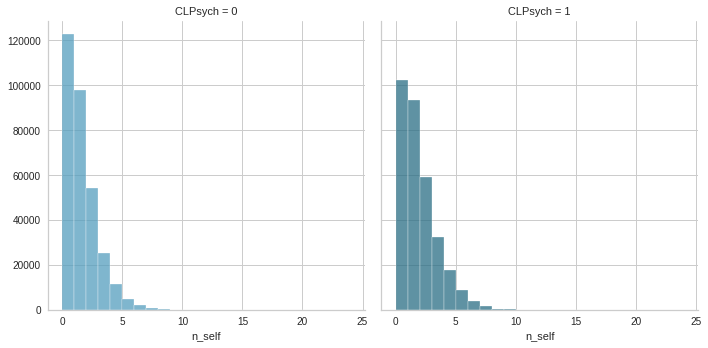


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_feelings
----------------------
            count      mean       std  min  25%  50%  75%  max
CLPsych                                                       
0        320000.0  0.004266  0.066077  0.0  0.0  0.0  0.0  3.0
1        320000.0  0.007409  0.087096  0.0  0.0  0.0  0.0  2.0



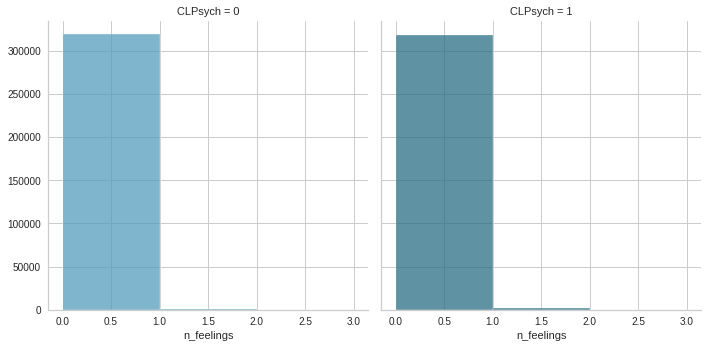


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_negation
----------------------
            count      mean       std  min  25%  50%  75%   max
CLPsych                                                        
0        320000.0  0.151272  0.410490  0.0  0.0  0.0  0.0  17.0
1        320000.0  0.167034  0.435922  0.0  0.0  0.0  0.0  23.0



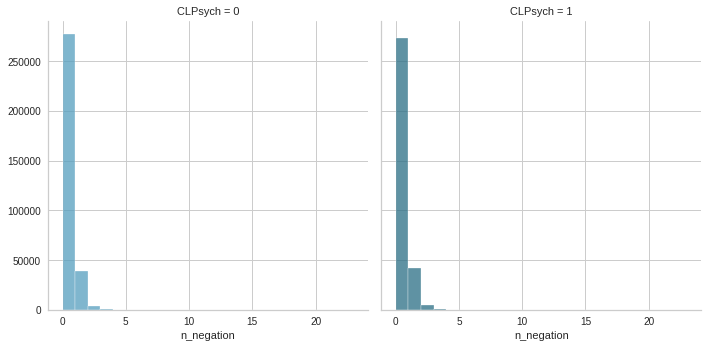


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_hopelessness
--------------------------
            count      mean       std  min  25%  50%  75%  max
CLPsych                                                       
0        320000.0  0.037894  0.202997  0.0  0.0  0.0  0.0  9.0
1        320000.0  0.042019  0.213988  0.0  0.0  0.0  0.0  4.0



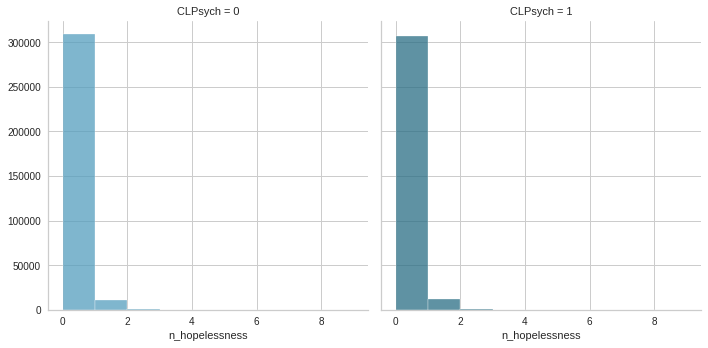


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_sufferance
------------------------
            count      mean       std  min  25%  50%  75%   max
CLPsych                                                        
0        320000.0  0.022806  0.159703  0.0  0.0  0.0  0.0  12.0
1        320000.0  0.027656  0.182340  0.0  0.0  0.0  0.0  28.0



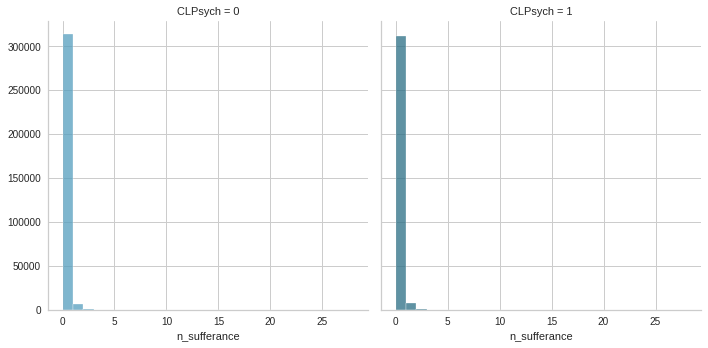


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_words
-------------------
            count       mean       std  min  25%   50%   75%    max
CLPsych                                                            
0        320000.0  12.656806  7.108593  0.0  7.0  12.0  18.0  125.0
1        320000.0  13.149394  7.561549  0.0  7.0  12.0  19.0  114.0



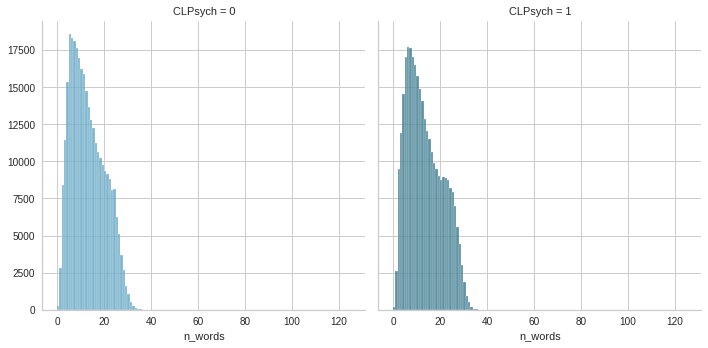


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_mentions
----------------------
            count      mean       std  min  25%  50%  75%   max
CLPsych                                                        
0        320000.0  0.740441  0.917240  0.0  0.0  1.0  1.0  13.0
1        320000.0  0.745050  0.867664  0.0  0.0  1.0  1.0  11.0



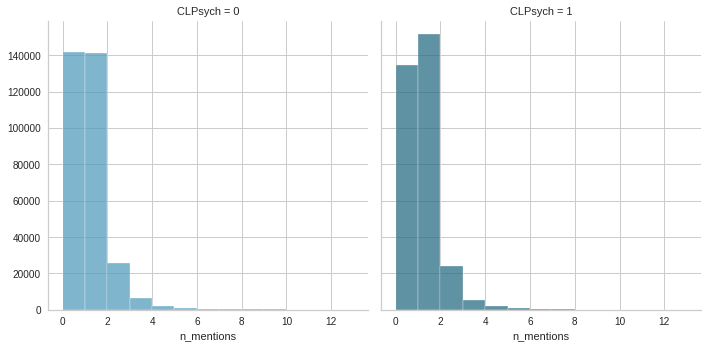


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_hashtags
----------------------
            count      mean       std  min  25%  50%  75%   max
CLPsych                                                        
0        320000.0  0.284941  0.798445  0.0  0.0  0.0  0.0  25.0
1        320000.0  0.159072  0.568903  0.0  0.0  0.0  0.0  24.0



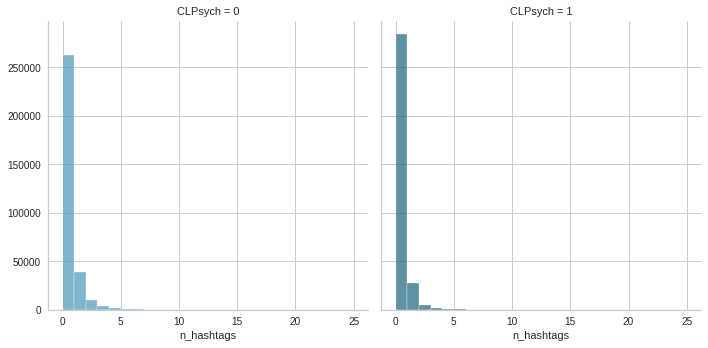


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_capitals
----------------------
            count       mean       std  min  25%   50%   75%    max
CLPsych                                                            
0        320000.0  10.432488  6.314293  0.0  5.0   9.0  15.0  123.0
1        320000.0  10.818172  6.709065  0.0  5.0  10.0  16.0  112.0



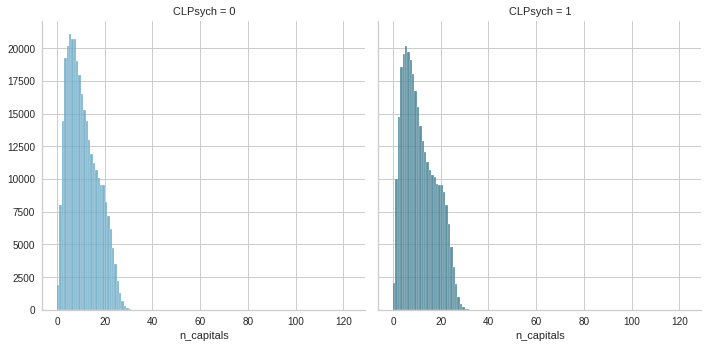


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_qe_marks
----------------------
            count      mean       std  min  25%  50%  75%    max
CLPsych                                                         
0        320000.0  0.444747  1.087997  0.0  0.0  0.0  1.0  104.0
1        320000.0  0.343725  1.044139  0.0  0.0  0.0  0.0  126.0



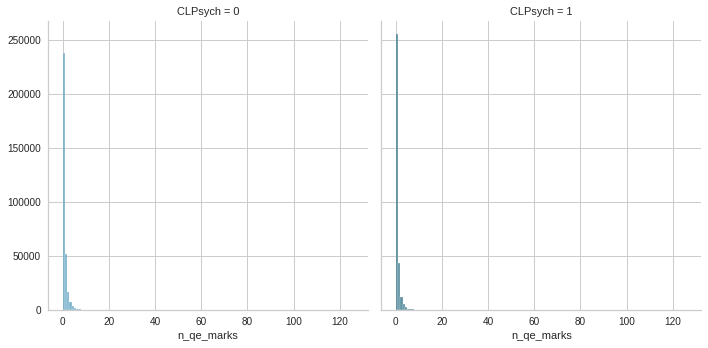


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_urls
------------------
            count      mean       std  min  25%  50%  75%  max
CLPsych                                                       
0        320000.0  0.236031  0.436981  0.0  0.0  0.0  0.0  5.0
1        320000.0  0.195178  0.412155  0.0  0.0  0.0  0.0  5.0



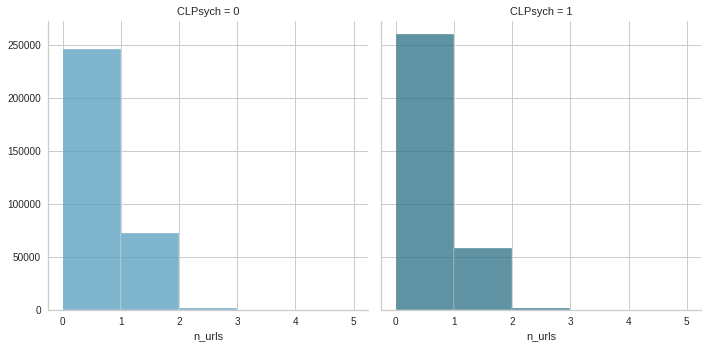


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_emoji
-------------------
            count      mean       std  min  25%  50%  75%   max
CLPsych                                                        
0        320000.0  0.119403  0.462240  0.0  0.0  0.0  0.0  52.0
1        320000.0  0.115544  0.533216  0.0  0.0  0.0  0.0  98.0



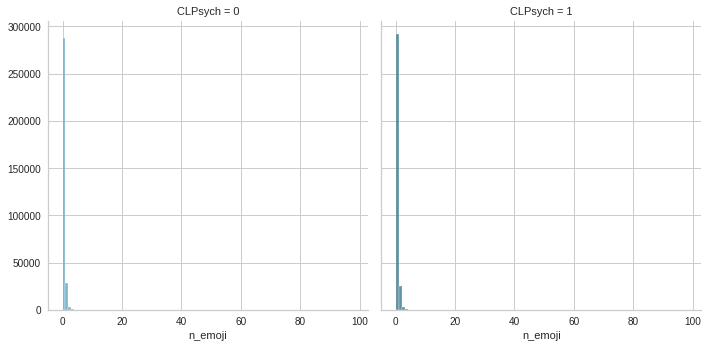

In [ ]:
for col in df_features.columns.to_list()[:-1]:
    # Statistics
    print()
    print('-*'*(len(col)+40))
    print('\n {}'.format(col))
    print('-'*(len(col)+12))
    print(df_features.groupby('CLPsych')[col].describe())
    print()
    
    # Plot
    bins = np.arange(df_features[col].min(), df_features[col].max() + 1)
    g = sns.FacetGrid(df_features, col='CLPsych', height=5, hue='CLPsych', palette="PuBuGn_d")
    g = g.map(sns.histplot, col, kde=False, bins=bins)
    plt.show()

### Hypothesis Test

Since our data set is considerably large, we can perform a **two sample Z-test with $\alpha = 1\%$** on each tweet feature to verify whether the difference between the mean of the two populations (depressed and control tweets) is statistically significant.   
If a feature passes the test, than we keep it as a new feature for our classification task, otherwise we discard it.  

According to our results, we can consider **all tested features statistically significant** with $99\%$ of confidence, except for *n_mentions*. Thus, we will keep all of the relevant features as input for our classification task.





In [ ]:
def twoSample_Ztest(mu1, mu2, sigma1, sigma2, n1, n2, alpha = 0.05):
    """ 
    Two sample Z-test.

    Parameters
    ----------
    - mu1, sigma1 [float]: mean and standard deviation of the first population.
    - mu2, sigma2 [float]: mean and standard deviation of the second population. 
    - n1, n2 [int]: population sizes
    - alpha [float]: alpha level [default 0.05]
    """

    ovr_sigma = np.sqrt(sigma1**2/n1 + sigma2**2/n2)
    z = (mu1 - mu2)/ovr_sigma
    p_val = 2*(1 - st.norm.cdf(abs(z)))
    print("Confidence: {:.1%}".format(1-alpha))
    if (p_val < alpha):
      print('p-value:', round(p_val,5), '\nThe difference between the mean of the two populations is \033[1mstatistically significant.\033[0m')
    else:
      print('p-value:', round(p_val,5), '\nThe difference between the mean of the two populations is \033[1m NOT statistically significant.\033[0m')

In [ ]:
for col in df_features.columns.to_list()[:-1]:

  print('\nHYPOTHESIS TEST ON {}'.format(col))
  print('-'*(len(col)+22))

  mu_pos = df_features.groupby('CLPsych')[col].mean().loc[1]
  mu_neg = df_features.groupby('CLPsych')[col].mean().loc[0]
  sigma_pos = df_features.groupby('CLPsych')[col].std().loc[1]
  sigma_neg = df_features.groupby('CLPsych')[col].std().loc[0]
  n_pos = Counter(df.CLPsych)[1]
  n_neg = Counter(df.CLPsych)[0]
  twoSample_Ztest(mu_pos, mu_neg, sigma_pos, sigma_neg, n_pos, n_neg, alpha = 0.01)



HYPOTHESIS TEST ON n_self
----------------------------
Confidence: 99.0%
p-value: 0.0 
The difference between the mean of the two populations is statistically significant.

HYPOTHESIS TEST ON n_feelings
--------------------------------
Confidence: 99.0%
p-value: 0.0 
The difference between the mean of the two populations is statistically significant.

HYPOTHESIS TEST ON n_negation
--------------------------------
Confidence: 99.0%
p-value: 0.0 
The difference between the mean of the two populations is statistically significant.

HYPOTHESIS TEST ON n_hopelessness
------------------------------------
Confidence: 99.0%
p-value: 0.0 
The difference between the mean of the two populations is statistically significant.

HYPOTHESIS TEST ON n_sufferance
----------------------------------
Confidence: 99.0%
p-value: 0.0 
The difference between the mean of the two populations is statistically significant.

HYPOTHESIS TEST ON n_words
-----------------------------
Confidence: 99.0%
p-value: 0.0 
T

# Classification

In the following cells we will go to classify tweets following different strategies. In particular, in the following cells different classifiers with different combinations of features are tested. By **features** we mean the features that have been extracted in the previous section.

For some of the classifiers a GridSearch was also created to find the best hyper-parameters.

The best result was obtained with this combination:

- **classifier**: Bernoulli Naive Bayes
- **input**: features + text vectorized through TF-IDF (concatenation of the dataset containing our features and of the sparse matrix resulting from the application of TF-IDF on the clean text).

##Prepare input data



### Features

In [ ]:
# Read input data
input_data_without_text = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/NLP_BigProject/input_data.pickle')

In [ ]:
# id <-> user
id2user = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/NLP_BigProject/id2user.pickle')
id2user

0             v_DcfumvuOV
1            t2uvlI9HPjg7
2           u1md0PCo9RzRm
3         pq4ZpkgLEpDnGXL
4         p4By1MygEKMA820
               ...       
639995       ldiulmWG1kZA
639996        pTcxQNJ4es1
639997       oW4Bal6UmO9Z
639998    lRAGYQpY__sVTDx
639999          wiAYbBlcv
Name: user_name, Length: 640000, dtype: object

In [ ]:
# Train and test data
X_train, X_test, y_train, y_test = train_test_split(input_data_without_text.drop('CLPsych', axis=1), 
                                                  input_data_without_text.CLPsych, 
                                                  test_size=0.2, 
                                                  random_state=SEED_VALUE)

In [ ]:
X_train

,cri,omg,mean,yeah,stop,everyon,two,help,okay,live,red,pleas follow,love much,follow love,see pleas,cherri blossom,would mean,thank much,follow would,heart red,mean world,realli need,even know,make feel,follow peopl,sparkl heart,welcometweet via,unfollow follow,make happi,first time,good night,happen see,blossom cherri,want get,sound like,follow unfollow,go go,blue heart,feel better,squint face,want know,much love,heart two,cross line,love lt,go bed,everi time,year ago,n_self,n_feelings,n_negation,n_hopelessness,n_sufferance,n_words,n_mentions,n_hashtags,n_capitals,n_qe_marks,n_urls,n_emoji
533305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,1
94259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,27,0,0,22,1,1,0
107731,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,24,0,0,21,2,0,0
260902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,21,0,0,17,0,0,0
24958,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,9,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,20,1,0,16,1,1,0
259178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,7,1,0,6,0,0,0
365838,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,10,1,0,7,0,0,0
131932,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,18,1,0,17,0,0,0


### Features + TF-IDF

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/NLP_BigProject/clean_text.pickle', 'rb') as f:
  clean_text = pickle.load(f)

In [ ]:
vectorizer = TfidfVectorizer()
vec = vectorizer.fit_transform(clean_text)


In [ ]:
# transform dataframe of our features into sparse matrix 
# to concatenate it with tf-idf sparse matrix 
df_sparse = scipy.sparse.csr_matrix(input_data_without_text.drop('CLPsych', axis=1).values)

In [ ]:
# concantenation of our features and vectorized text 
df = hstack((df_sparse, vectorized_text))

In [ ]:
# Train and test data
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                  input_data_without_text.CLPsych, 
                                                  test_size=0.2, 
                                                  random_state=SEED_VALUE)

In [ ]:
X_train.shape

(512000, 151591)

In [ ]:
y_train.shape

(512000,)

### TF-IDF

In [ ]:
# Train and test data
X_train, X_test, y_train, y_test = train_test_split(clean_text, 
                                                  input_data_without_text.CLPsych, 
                                                  test_size=0.2, 
                                                  random_state=SEED_VALUE)

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Features + BoW

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/NLP_BigProject/clean_text.pickle', 'rb') as f:
  clean_text = pickle.load(f)

In [ ]:
vectorizer = CountVectorizer()
vec = vectorizer.fit_transform(clean_text)


In [ ]:
# transform dataframe of our features into sparse matrix 
# to concatenate it with BoW sparse matrix 
df_sparse = scipy.sparse.csr_matrix(input_data_without_text.drop('CLPsych', axis=1).values)

In [ ]:
df = hstack((df_sparse, vec))

In [ ]:
# Train and test data
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                  input_data_without_text.CLPsych, 
                                                  test_size=0.2, 
                                                  random_state=SEED_VALUE)

### BoW 

In [ ]:
# Train and test data
X_train, X_test, y_train, y_test = train_test_split(clean_text, 
                                                  input_data_without_text.CLPsych, 
                                                  test_size=0.2, 
                                                  random_state=SEED_VALUE)

In [ ]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Classifiers features

### Logistic Regression

**Best result**: 
- max_iter = 1000
- accuracy =  0.5650234375

In [ ]:
######################
# Perform GridSearch #
######################

# Parameters for classifier
max_iter = [[100], [1000]]
grid_clf = {'max_iter': max_iter}

param_grid_clf = ParameterGrid(grid_clf)

# GridSearch on clf 
grid_search = GridSearchCV(LogisticRegression(), param_grid_clf, cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0), scoring = "accuracy", refit = True)

# Grid Search
print("   Performing grid search...")
t0 = time()
grid_search.fit(X_train, y_train)
print("\nDone in %0.3fs" % (time() - t0))
print()

best_clf_params = grid_search.best_params_

# Extract best classifier 
best_clf = grid_search.best_estimator_




   Performing grid search...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Done in 265.190s



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Testing
print("   Testing...")
pred = best_clf.predict(X_test) #predict the sentiment for test data
accuracy = best_clf.score(X_test, y_test)
#f1 = f1_score(Y_test, pred)
print("Accuracy: %s" % str(accuracy)) #check accuracy

   Testing...
Accuracy: 0.5650234375


### SVM
**Best result**: 
- alpha=0.14210526315789473
- accuracy = 0.5425

In [ ]:
######################
# Perform GridSearch #
######################

# Parameters for classifier
alpha = [tuple(np.linspace(0.1,0.5,20))]
grid_clf = {'alpha': alpha}

param_grid_clf = ParameterGrid(grid_clf)

# GridSearch on clf 
grid_search = GridSearchCV(SGDClassifier(), param_grid_clf, cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0), scoring = "accuracy", refit = True)

# Grid Search
print("   Performing grid search...")
t0 = time()
grid_search.fit(X_train, y_train)
print("\nDone in %0.3fs" % (time() - t0))
print()

best_clf_params = grid_search.best_params_

# Extract best classifier 
best_clf = grid_search.best_estimator_




   Performing grid search...

Done in 141.085s



In [ ]:
# Testing
print("   Testing...")
pred = best_clf.predict(X_test) #predict the sentiment for test data
accuracy = best_clf.score(X_test, y_test)
#f1 = f1_score(Y_test, pred)
print("Best clf", str(best_clf))
print("Accuracy: %s" % str(accuracy)) #check accuracy

   Testing...
Best clf SGDClassifier(alpha=0.14210526315789473, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy: 0.5425


### Bernoulli 

**Result**:
- accuracy = 0.56

In [ ]:
clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, y_test)

In [ ]:
accuracy

0.5608359375

### Random Forest

**Result**
- accuracy: 0.5691796875

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, y_test)

In [ ]:
accuracy

0.5691796875

## Classifiers features + TF-IDF

### Logistic Regression

**Best result**: 
- max_iter = 1000
- accuracy = 0.58278125

In [ ]:
######################
# Perform GridSearch #
######################

# Parameters for classifier
max_iter = [[100], [1000]]
grid_clf = {'max_iter': max_iter}

param_grid_clf = ParameterGrid(grid_clf)

# GridSearch on clf 
grid_search = GridSearchCV(LogisticRegression(), param_grid_clf, cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0), scoring = "accuracy", refit = True)

# Grid Search
print("   Performing grid search...")
t0 = time()
grid_search.fit(X_train, y_train)
print("\nDone in %0.3fs" % (time() - t0))
print()

best_clf_params = grid_search.best_params_

# Extract best classifier 
best_clf = grid_search.best_estimator_




   Performing grid search...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Done in 330.295s



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Testing
print("   Testing...")
pred = best_clf.predict(X_test) #predict the sentiment for test data
accuracy = best_clf.score(X_test, y_test)
print("Best clf", str(best_clf))
#f1 = f1_score(Y_test, pred)
print("Accuracy: %s" % str(accuracy)) #check accuracy

   Testing...
Best clf LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.58278125


### SVM
**Best result**: 
- alpha= 0.1
- accuracy = 0.55390625

In [ ]:
######################
# Perform GridSearch #
######################

# Parameters for classifier
alpha = [tuple(np.linspace(0.1,0.5,20))]
grid_clf = {'alpha': alpha}

param_grid_clf = ParameterGrid(grid_clf)

# GridSearch on clf 
grid_search = GridSearchCV(SGDClassifier(), param_grid_clf, cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0), scoring = "accuracy", refit = True)

# Grid Search
print("   Performing grid search...")
t0 = time()
grid_search.fit(X_train, y_train)
print("\nDone in %0.3fs" % (time() - t0))
print()

best_clf_params = grid_search.best_params_

# Extract best classifier 
best_clf = grid_search.best_estimator_




   Performing grid search...

Done in 105.362s



In [ ]:
# Testing
print("   Testing...")
pred = best_clf.predict(X_test) #predict the sentiment for test data
accuracy = best_clf.score(X_test, y_test)
#f1 = f1_score(Y_test, pred)
print("Best clf", str(best_clf))
print("Accuracy: %s" % str(accuracy)) #check accuracy

   Testing...
Best clf SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy: 0.55390625


### Bernoulli 

**Result**:
- accuracy = 0.652390625

In [ ]:
clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, y_test)

In [ ]:
accuracy

0.652390625

### Random Forest

**Result**
- accuracy: 0.5590859375

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, y_test)

In [ ]:
accuracy

0.5590859375

## Classifiers TF-IDF

### Logistic Regression

**Best result**: 
- max_iter = 1000
- accuracy = 0.649921875

In [ ]:
######################
# Perform GridSearch #
######################

# Parameters for classifier
max_iter = [[100], [1000]]
grid_clf = {'max_iter': max_iter}

param_grid_clf = ParameterGrid(grid_clf)

# GridSearch on clf 
grid_search = GridSearchCV(LogisticRegression(), param_grid_clf, cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0), scoring = "accuracy", refit = True)

# Grid Search
print("   Performing grid search...")
t0 = time()
grid_search.fit(X_train, y_train)
print("\nDone in %0.3fs" % (time() - t0))
print()

best_clf_params = grid_search.best_params_

# Extract best classifier 
best_clf = grid_search.best_estimator_




   Performing grid search...

Done in 170.187s



In [ ]:
# Testing
print("   Testing...")
pred = best_clf.predict(X_test) #predict the sentiment for test data
accuracy = best_clf.score(X_test, y_test)
print("Best clf", str(best_clf))
#f1 = f1_score(Y_test, pred)
print("Accuracy: %s" % str(accuracy)) #check accuracy

### SVM
**Best result**: 
- alpha= 0.2894736842105263
- accuracy = 0.5015234375

In [ ]:
######################
# Perform GridSearch #
######################

# Parameters for classifier
alpha = [tuple(np.linspace(0.1,0.5,20))]
grid_clf = {'alpha': alpha}

param_grid_clf = ParameterGrid(grid_clf)

# GridSearch on clf 
grid_search = GridSearchCV(SGDClassifier(), param_grid_clf, cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0), scoring = "accuracy", refit = True)

# Grid Search
print("   Performing grid search...")
t0 = time()
grid_search.fit(X_train, y_train)
print("\nDone in %0.3fs" % (time() - t0))
print()

best_clf_params = grid_search.best_params_

# Extract best classifier 
best_clf = grid_search.best_estimator_




   Performing grid search...

Done in 23.871s



In [ ]:
# Testing
print("   Testing...")
pred = best_clf.predict(X_test) #predict the sentiment for test data
accuracy = best_clf.score(X_test, y_test)
#f1 = f1_score(Y_test, pred)
print("Best clf", str(best_clf))
print("Accuracy: %s" % str(accuracy)) #check accuracy

   Testing...
Best clf SGDClassifier(alpha=0.2894736842105263, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy: 0.5015234375


### Bernoulli 

**Result**:
- accuracy =0.6493984375

In [ ]:
clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, y_test)

In [ ]:
accuracy

0.6493984375

### Random Forest

**Result**
- accuracy: 0.5479375

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, y_test)

In [ ]:
accuracy

0.5479375

## Classifiers features + BoW

### Logistic Regression

**Best result**: 
- max_iter = 1000
- accuracy = 0.5976875

In [ ]:
######################
# Perform GridSearch #
######################

# Parameters for classifier
max_iter = [[100], [1000]]
grid_clf = {'max_iter': max_iter}

param_grid_clf = ParameterGrid(grid_clf)

# GridSearch on clf 
grid_search = GridSearchCV(LogisticRegression(), param_grid_clf, cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0), scoring = "accuracy", refit = True)

# Grid Search
print("   Performing grid search...")
t0 = time()
grid_search.fit(X_train, y_train)
print("\nDone in %0.3fs" % (time() - t0))
print()

best_clf_params = grid_search.best_params_

# Extract best classifier 
best_clf = grid_search.best_estimator_




   Performing grid search...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Done in 357.755s



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Testing
print("   Testing...")
pred = best_clf.predict(X_test) #predict the sentiment for test data
accuracy = best_clf.score(X_test, y_test)
print("Best clf", str(best_clf))
#f1 = f1_score(Y_test, pred)
print("Accuracy: %s" % str(accuracy)) #check accuracy

   Testing...
Best clf LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.5976875


### SVM
**Best result**: 
- alpha=0.1631578947368421
- accuracy = 0.5568203125

In [ ]:
######################
# Perform GridSearch #
######################

# Parameters for classifier
alpha = [tuple(np.linspace(0.1,0.5,20))]
grid_clf = {'alpha': alpha}

param_grid_clf = ParameterGrid(grid_clf)

# GridSearch on clf 
grid_search = GridSearchCV(SGDClassifier(), param_grid_clf, cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0), scoring = "accuracy", refit = True)

# Grid Search
print("   Performing grid search...")
t0 = time()
grid_search.fit(X_train, y_train)
print("\nDone in %0.3fs" % (time() - t0))
print()

best_clf_params = grid_search.best_params_

# Extract best classifier 
best_clf = grid_search.best_estimator_




   Performing grid search...

Done in 125.013s



In [ ]:
# Testing
print("   Testing...")
pred = best_clf.predict(X_test) #predict the sentiment for test data
accuracy = best_clf.score(X_test, y_test)
#f1 = f1_score(Y_test, pred)
print("Best clf", str(best_clf))
print("Accuracy: %s" % str(accuracy)) #check accuracy

   Testing...
Best clf SGDClassifier(alpha=0.1631578947368421, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy: 0.5568203125


### Bernoulli 

**Result**:
- accuracy = 0.652390625

In [ ]:
clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, y_test)

In [ ]:
accuracy

0.652390625

### Random Forest

**Result**
- accuracy:0.55690625

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, y_test)

In [ ]:
accuracy

0.55690625

## Classifiers BoW

### Logistic Regression

**Best result**: 
- max_iter = 1000
- accuracy = 0.6507890625

In [ ]:
######################
# Perform GridSearch #
######################

# Parameters for classifier
max_iter = [[100], [1000]]
grid_clf = {'max_iter': max_iter}

param_grid_clf = ParameterGrid(grid_clf)

# GridSearch on clf 
grid_search = GridSearchCV(LogisticRegression(), param_grid_clf, cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0), scoring = "accuracy", refit = True)

# Grid Search
print("   Performing grid search...")
t0 = time()
grid_search.fit(X_train, y_train)
print("\nDone in %0.3fs" % (time() - t0))
print()

best_clf_params = grid_search.best_params_

# Extract best classifier 
best_clf = grid_search.best_estimator_




   Performing grid search...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Done in 225.664s



In [ ]:
# Testing
print("   Testing...")
pred = best_clf.predict(X_test) #predict the sentiment for test data
accuracy = best_clf.score(X_test, y_test)
print("Best clf", str(best_clf))
#f1 = f1_score(Y_test, pred)
print("Accuracy: %s" % str(accuracy)) #check accuracy

   Testing...
Best clf LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.6507890625


### SVM
**Best result**: 
- alpha= 0.2894736842105263
- accuracy = 0.5105234375

In [ ]:
######################
# Perform GridSearch #
######################

# Parameters for classifier
alpha = [tuple(np.linspace(0.1,0.5,20))]
grid_clf = {'alpha': alpha}

param_grid_clf = ParameterGrid(grid_clf)

# GridSearch on clf 
grid_search = GridSearchCV(SGDClassifier(), param_grid_clf, cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0), scoring = "accuracy", refit = True)

# Grid Search
print("   Performing grid search...")
t0 = time()
grid_search.fit(X_train, y_train)
print("\nDone in %0.3fs" % (time() - t0))
print()

best_clf_params = grid_search.best_params_

# Extract best classifier 
best_clf = grid_search.best_estimator_




   Performing grid search...

Done in 23.421s



In [ ]:
# Testing
print("   Testing...")
pred = best_clf.predict(X_test) #predict the sentiment for test data
accuracy = best_clf.score(X_test, y_test)
#f1 = f1_score(Y_test, pred)
print("Best clf", str(best_clf))
print("Accuracy: %s" % str(accuracy)) #check accuracy

   Testing...
Best clf SGDClassifier(alpha=0.2894736842105263, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy: 0.5105234375


### Bernoulli 

**Result**:
- accuracy =0.6493984375

In [ ]:
clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, y_test)

In [ ]:
accuracy

0.6493984375

### Random Forest

**Result**
- accuracy: 0.54665625

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, y_test)

In [ ]:
accuracy

0.54665625

# Validation: from depressed tweets to depressed users

In the following cells we will run the strategy (input data features + classifier) ​​which turned out to be the best in the previous section.

----


**Prediction**

After running the classifier on the training set we are going to predict the label that indicates the state of depression for each tweet. At this point  we will have the **label** associated with each tweet (CLPsych User -> Tweet) **based on the user's depression status** (if the user was characterized as depressed, the CLPsychs label will be equal to **1** for all tweets of that user) and the **label** associated with each tweet **based on the prediction of the classifier**.

---


**Validation**

To evaluate the validity of our approach we will count, for each group of tweets of each user, the number of predictions on the single tweets that correspond to the real label indicating the user's status. We will then go on to set threshold values ​​to see how accurate our classifier is in the task of carrying out the **reverse process**, that is to pass **from the knowledge of the depression state of the tweet to the knowledge of the user's depression state (gold-standard)**.

--

**Results**
From the analysis carried out it emerges that:
- with a threshold of 50%, 40.34% of users are classified correctly
- with a threshold of 60%, 12.88% of users are classified correctly
- with a threshold of 70%, 8.99% of users are classified correctly
- with a threshold of 80%, 5.83% of users are classified correctly
- with a 90% threshold, 4.74% of users are classified correctly

---

**Conclusions**

The accuracy of the classification is too low to be able to generalize this method to predicting depression on COVID19 tweets.

Our method includes several steps and in each of them we can highlight some critical issues that may have led to a similar result. We will analyze the various difficulties within the report of our project.

## Run best classifier

In [ ]:
# Read input data
input_data_without_text = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/NLP_BigProject/input_data.pickle')

In [ ]:
input_data_without_text.head()

,cri,omg,mean,yeah,stop,everyon,two,help,okay,live,red,pleas follow,love much,follow love,see pleas,cherri blossom,would mean,thank much,follow would,heart red,mean world,realli need,even know,make feel,follow peopl,sparkl heart,welcometweet via,unfollow follow,make happi,first time,good night,happen see,blossom cherri,want get,sound like,follow unfollow,go go,blue heart,feel better,squint face,want know,much love,heart two,cross line,love lt,go bed,everi time,year ago,n_self,n_feelings,n_negation,n_hopelessness,n_sufferance,n_words,n_mentions,n_hashtags,n_capitals,n_qe_marks,n_urls,n_emoji,CLPsych
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1,0,6,0,0,0,1
1,0,0,0,0,0,0,0,0,0,960,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,1,1,20,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6,0,0,5,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,9,1,0,9,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,26,1,0,26,4,0,0,1


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/NLP_BigProject/clean_text.pickle', 'rb') as f:
  clean_text = pickle.load(f)

In [ ]:
# id <-> user
id2user = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/NLP_BigProject/id2user.pickle')
id2user

0             v_DcfumvuOV
1            t2uvlI9HPjg7
2           u1md0PCo9RzRm
3         pq4ZpkgLEpDnGXL
4         p4By1MygEKMA820
               ...       
639995       ldiulmWG1kZA
639996        pTcxQNJ4es1
639997       oW4Bal6UmO9Z
639998    lRAGYQpY__sVTDx
639999          wiAYbBlcv
Name: user_name, Length: 640000, dtype: object

In [ ]:
vectorizer = TfidfVectorizer()
vectorized_text = vectorizer.fit_transform(clean_text)

In [ ]:
df_sparse = scipy.sparse.csr_matrix(input_data_without_text.drop('CLPsych', axis=1).values)

In [ ]:
df = hstack((df_sparse, vectorized_text))

In [ ]:
# Train and test data
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                  input_data_without_text.CLPsych, 
                                                  test_size=0.2, 
                                                  random_state=SEED_VALUE)

In [ ]:
clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

## Predictions

In [ ]:
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, y_test)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.652390625


In [ ]:
len(pred)

128000

In [ ]:
# compute predictions on the whole dataset
predictions = clf.predict(df)

In [ ]:
len(predictions)

640000

In [ ]:
# create dataframe with prediction and true labels
pred_true_lab = (np.vstack([input_data_without_text.CLPsych, predictions])).T

In [ ]:
pred_true_lab[0]

array([1, 1])

## Tweets -> User

In [ ]:
# number of distinct users 
id2user.nunique()

823

In [ ]:
# list of unique users
user_list = []
for user in id2user:
  if user not in user_list: 
    user_list.append(user)

In [ ]:
# dictionary initialization 
user_index_tweet={}

In [ ]:
# instatiate an empty list for each user 
for user in user_list: 
  user_index_tweet[user] = list()

In [ ]:
# add the index of each tweet of a specific user 
# {user: index_tweet_1, index_tweet_2,..., index_tweet_n}
# indexes of our input data correspond to the indexes of the tweets 
i_tweet = 0
for user in id2user: 
  for unique_user in user_list: 
    if user == unique_user: 
      user_index_tweet[unique_user].append(i_tweet)
  
  i_tweet+=1


In [ ]:
user_index_tweet

In [ ]:
# check that the true label of a single user is always the same 
for k, v in user_index_tweet.items(): 
  for index in v: 
    print(pred_true_lab[index][0], pred_true_lab[index][1])
  break

Let's memorize the prediction as the threshold changes in a dictionary of this type: **{user: [true_label, 50%, 60%, 70%, 80%, 90%]}**

The thresholds specified in the dictionary have the following meaning: **threshold_percentage** is the number of correct predictions that you need to be able to associate the real label with the user. 

For example 50% means that if at least 50% of predictions on the tweets of a specific user correspond to the user's real label, then the user will be marked with the real label.


In [ ]:
results = {} #{user: [true_label, 50%, 60%, 70%, 80%, 90%]}
for k, v in user_index_tweet.items(): 
  count_predictions = 0
  true_lab = pred_true_lab[index][0]
  for index in v:
    if pred_true_lab[index][1] == true_lab: 
      count_predictions+=1

  if count_predictions > len(v)*0.5: 
    s1 = 1
  else: 
    s1 = 0 

  if count_predictions > len(v)*0.6: 
    s2 = 1
  else: 
    s2 = 0    

  if count_predictions > len(v)*0.7: 
    s3 = 1
  else: 
    s3 = 0    

  if count_predictions > len(v)*0.8: 
    s4 = 1
  else: 
    s4 = 0    

  if count_predictions > len(v)*0.9: 
    s5 = 1
  else: 
    s5 = 0   
  results[k] = [pred_true_lab[v[0]][0], s1, s2, s3, s4, s5]





In [ ]:
len(results.keys())

823

In [ ]:
results

{'0RjjaEK2565y': [1, 0, 0, 0, 0, 0],
 '0c30XN07oVtY': [0, 1, 0, 0, 0, 0],
 '1vPaiLkYsMMe': [0, 0, 0, 0, 0, 0],
 '7RYeUFUJNmh': [0, 1, 0, 0, 0, 0],
 '7wTSGz8sdXvD0K': [0, 1, 1, 0, 0, 0],
 'CwIBiOYVhktCx': [0, 0, 0, 0, 0, 0],
 'EyY0fWD5y': [1, 1, 1, 1, 0, 0],
 'FLgceR4pkHy9A54': [1, 1, 1, 1, 1, 0],
 'I15JlOLy4p5w7hH': [0, 1, 0, 0, 0, 0],
 'I7bkicO_Tml': [0, 1, 1, 1, 0, 0],
 'L844xvCOIjDJ3ot': [1, 1, 1, 1, 0, 0],
 'QIbT5IkcWpj': [1, 0, 0, 0, 0, 0],
 'QuEyiOpsAW1tH54': [0, 0, 0, 0, 0, 0],
 'QyvPvRhWp': [0, 0, 0, 0, 0, 0],
 'RLITyyHB': [0, 1, 1, 1, 1, 1],
 'VArDKZCMfZEYhnj': [0, 0, 0, 0, 0, 0],
 'b2WSKSO_G': [1, 0, 0, 0, 0, 0],
 'b3I8VQHJthg4': [1, 1, 1, 1, 1, 0],
 'b7JDj_Sb': [0, 1, 0, 0, 0, 0],
 'b90Xd3CWW': [0, 1, 1, 1, 1, 1],
 'b9b9ovP': [0, 0, 0, 0, 0, 0],
 'bBQyac_Tj3m': [0, 1, 1, 1, 1, 1],
 'bBVNVrXdoks3': [0, 0, 0, 0, 0, 0],
 'bBj3tEy': [0, 0, 0, 0, 0, 0],
 'bCNKKsY': [0, 1, 1, 1, 1, 1],
 'bFG_OQE4b': [0, 0, 0, 0, 0, 0],
 'bGhxiYfqcJluMYY': [1, 0, 0, 0, 0, 0],
 'bHa2It_8FSPtW': [1, 

In [ ]:
# numeber of correct predictions for each threshold 
correct_50 = 0 
correct_60 = 0 
correct_70 = 0 
correct_80 = 0 
correct_90 = 0 
for v in results.values(): 
  if v[0] == v[1]: 
    correct_50+=1
  elif v[0] == v[2]: 
    correct_60+=1
  elif v[0] == v[3]: 
    correct_70+=1
  elif v[0] == v[4]: 
    correct_80+=1
  elif v[0] == v[5]: 
    correct_90+=1
    

In [ ]:
correct_50, correct_60, correct_70, correct_80, correct_90

(332, 106, 74, 48, 39)

In [ ]:
print("Accuracy threhsold 50%: {}".format((correct_50/len(results.keys())*100)))
print("Accuracy threhsold 60%: {}".format((correct_60/len(results.keys())*100)))
print("Accuracy threhsold 70%: {}".format((correct_70/len(results.keys())*100)))
print("Accuracy threhsold 80%: {}".format((correct_80/len(results.keys())*100)))
print("Accuracy threhsold 90%: {}".format((correct_90/len(results.keys())*100)))

Accuracy threhsold 50%: 40.34021871202916
Accuracy threhsold 60%: 12.879708383961116
Accuracy threhsold 70%: 8.99149453219927
Accuracy threhsold 80%: 5.83232077764277
Accuracy threhsold 90%: 4.738760631834751
